# Big Brother - Healthcare edition

### Building a classifier using the [fastai](https://www.fast.ai/) library 

In [1]:
from fastai.tabular import *

In [2]:
#hide
path = Path('./covid19_ml_education')

In [3]:
#hide
df = pd.read_csv(path/'covid_ml.csv')

In [4]:
df.head(3)

,ID,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency_of_admission,...,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,date_death_or_discharge,source
0,1,30.0,male,No,No,No,No,No,No,Low,...,Anhui,China,31.646960,117.716600,admin3,2020-01-18,2020-01-20,2020-01-22,NaN,http://ah.people.com.cn/GB/n2/2020/0127/c35826...
1,2,47.0,male,No,No,No,No,No,No,Low,...,Anhui,China,31.778630,117.331900,admin3,2020-01-10,2020-01-21,2020-01-23,NaN,http://ah.people.com.cn/GB/n2/2020/0127/c35826...
2,3,49.0,male,No,No,No,No,No,No,Low,...,Anhui,China,31.828313,117.224844,point,2020-01-15,2020-01-20,2020-01-23,NaN,http://ah.people.com.cn/GB/n2/2020/0127/c35826...


## Independent variable

This is the value we want to predict

In [5]:
y_col = 'urgency_of_admission'

## Dependent variable

The values on which we can make a prediciton

In [6]:
cat_names = ['sex', 'cough', 'fever', 'chills', 'sore_throat', 'headache', 'fatigue']

In [7]:
cat_names = ['sex', 'cough', 'fever', 'headache', 'fatigue']

In [8]:
cont_names = ['age']

In [9]:
#hide
procs = [FillMissing, Categorify, Normalize]

In [148]:
#hide
test = TabularList.from_df(df.iloc[660:861].copy(), path = path, cat_names= cat_names, cont_names = cont_names)

In [11]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs = procs)
         .split_by_rand_pct(0.2)
         .label_from_df(cols=y_col)
#          .add_test(test)
         .databunch()   )

In [12]:
data.show_batch(rows=5)

sex,cough,fever,headache,fatigue,age_na,age,target
male,No,No,No,No,False,-0.6647,High
female,Yes,Yes,No,No,False,0.8230,Low
male,No,No,No,No,False,-1.0217,Low
male,No,No,No,No,False,2.0131,Low
female,No,No,No,No,False,-0.1886,High


## Model

Here we build our machine learning model that will learn from the dataset to classify between patients

### Using Focal Loss

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()


In [337]:
learn = tabular_learner(data, layers = [150,50], \
                        metrics = [accuracy,FBeta("macro")])

In [338]:
learn.loss_func = FocalLoss()

In [341]:
#hide
learn.fit_one_cycle(5, 1e-4, wd=  0.2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.673548,0.680910,0.558140,0.547395,00:00
1,0.673931,0.678851,0.540698,0.529213,00:00
2,0.671459,0.677479,0.581395,0.561890,00:00
3,0.670714,0.677923,0.593023,0.566667,00:00
4,0.670961,0.677307,0.593023,0.566667,00:00


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [355]:
learn.save('150-50-focal')

In [356]:
learn.export('150-50-focal.pth')

In [38]:
#hide
testdf = df.iloc[660:861].copy()

In [19]:
testdf.urgency.value_counts()

NameError: name 'testdf' is not defined

In [63]:
testdf.head()

,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
0,male,No,No,No,No,No,No,Low
1,male,No,Yes,No,No,No,No,High
2,male,Yes,Yes,No,Yes,No,No,Low
3,male,No,No,No,No,No,No,Low
4,male,No,Yes,No,No,Yes,No,Low


In [342]:
testdf = testdf.iloc[:,1:]

In [343]:
#hide
testdf.insert(0, 'predictions','')

In [344]:
#hide
for i in range(len(testdf)):
    row = testdf.iloc[i][1:]
    testdf.predictions.iloc[i] = str(learn.predict(row)[0])

### Making predictions

We've taken out a test set to see how well our model works, by making predictions on them.

Interestingly, all those predicted with 'High' urgency have a common trait of absence of **chills** and **sore throat**

In [345]:
testdf.urgency.value_counts()

Low     123
High     45
Name: urgency, dtype: int64

In [346]:
testdf.predictions.value_counts()

Low     90
High    78
Name: predictions, dtype: int64

In [347]:
from sklearn.metrics import classification_report

In [348]:
print(classification_report(testdf.predictions, testdf.urgency, labels = ["High", "Low"]))

              precision    recall  f1-score   support

        High       0.60      0.35      0.44        78
         Low       0.59      0.80      0.68        90

    accuracy                           0.59       168
   macro avg       0.59      0.57      0.56       168
weighted avg       0.59      0.59      0.57       168



In [301]:
print(classification_report(testdf.predictions, testdf.urgency, labels = ["High", "Low"]))

              precision    recall  f1-score   support

        High       0.40      0.35      0.37        52
         Low       0.72      0.77      0.74       116

    accuracy                           0.64       168
   macro avg       0.56      0.56      0.56       168
weighted avg       0.62      0.64      0.63       168



In [180]:
testdf = pd.read_csv('processed_over_test.csv')

In [181]:
testdf = testdf.iloc[:,1:]

In [182]:
testdf.head()

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
0,49.0,1,0,0,0,0,0,0,0
1,60.0,1,0,1,0,0,0,0,1
2,41.0,1,1,1,0,1,0,0,0
3,71.0,1,0,0,0,0,0,0,0
4,50.0,1,0,1,0,0,1,0,0


In [183]:
yesnomapper = {1:'Yes', 0: 'No'}

In [184]:
for col in testdf.columns[2:-1]:
    testdf[col]= testdf[col].map(yesnomapper)

In [185]:
testdf['sex'] = testdf['sex'].map({1: 'male', 0:'female'})

In [186]:
testdf['urgency'] = testdf['urgency'].map({0:'Low', 1:'High'})

In [349]:
from sklearn.metrics import confusion_matrix

In [350]:
cm_test = confusion_matrix(testdf.urgency, testdf.predictions)

In [351]:
cm_test

array([[27, 18],
       [51, 72]])

In [352]:
cm_test = np.array([[72, 51], [18,27]])

In [353]:
cm_test

array([[72, 51],
       [18, 27]])

In [129]:
cm_test2 = np.array([[94, 29],[30,15]])

In [134]:
df_cm

,Predicted Low,Predicted High
Actual Low,15,30
Actual High,29,94


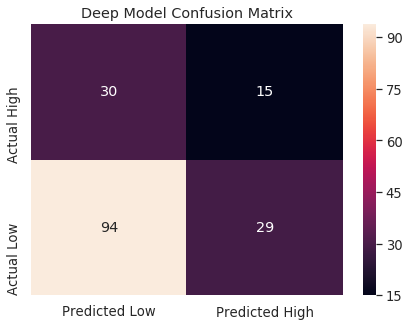

In [137]:
import seaborn as sn
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
df_cm = pd.DataFrame(cm_test2, index = ['Actual Low','Actual High'],
                  columns = ['Predicted Low','Predicted High'])
sns.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, ax = ax)
ax.set_ylim([0,2]);
ax.set_title('Deep Model Confusion Matrix')
fig.savefig('DeepModel_CM.png')

## Profile after focal loss

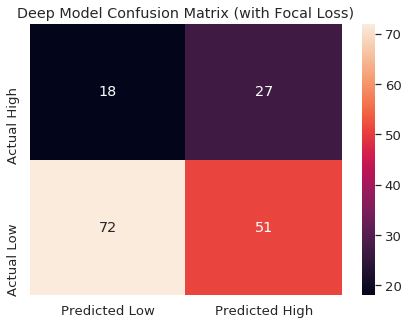

In [354]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots()
fig.set_size_inches(7,5)
df_cm = pd.DataFrame(cm_test, index = ['Actual Low','Actual High'],
                  columns = ['Predicted Low','Predicted High'])
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True, ax = ax)
ax.set_ylim([0,2]);
ax.set_title('Deep Model Confusion Matrix (with Focal Loss)');
fig.savefig('DeepModel_CM_Focal Loss.png')